<a href="https://colab.research.google.com/gist/KhawajaMuddassar/ac59c00a7b63babfd256e1419c72d030/clip-semantic-image-search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **CLIP (Contrastive Language-Image Pre-training)**

**Contrastive learning** is a technique used in machine learning, particularly in the field of unsupervised learning where we teach an AI model to recognize similarities and differences of a large number of data points.

Contrastive Language-Image Pre-training (CLIP) is a multimodal vision and language model architecture developed by OpenAI that learns visual concepts from natural language descriptions. It can be used for image-text similarity and for zero-shot image classification. Its effectiveness comes from a large-scale, diverse dataset of images and texts.


**CLIP Architecture:**
Contrastive Language-Image Pre-training (CLIP) uses a dual-encoder architecture to map images and text into a shared latent space and it works by jointly training two encoders. One encoder for images (Vision Transformer for visual features) and one for text (Transformer-based language model for text features).

 * **Image Encoder:** The image encoder extracts salient features from the visual input. This encoder takes an 'image as input' and produces a high-dimensional vector representation. It typically uses a ViT / convolutional neural network (CNN) architecture, like ResNet, for extracting image features.

* **Text Encoder:** The text encoder encodes the semantic meaning of the corresponding textual description. It takes a 'text caption/label as input' and produces another high-dimensional vector representation. It often uses a transformer-based architecture, like a Transformer or BERT, to process text sequences.

* **Shared Embedding Space / Laten Space:** Both the text and visual features are then projected to a latent space with identical dimension. The dot product between the projected image and text features is then used as a similar score. These shared embedding spaces allow CLIP to compare text and image representations and learn their underlying relationships.



**Training Process:**

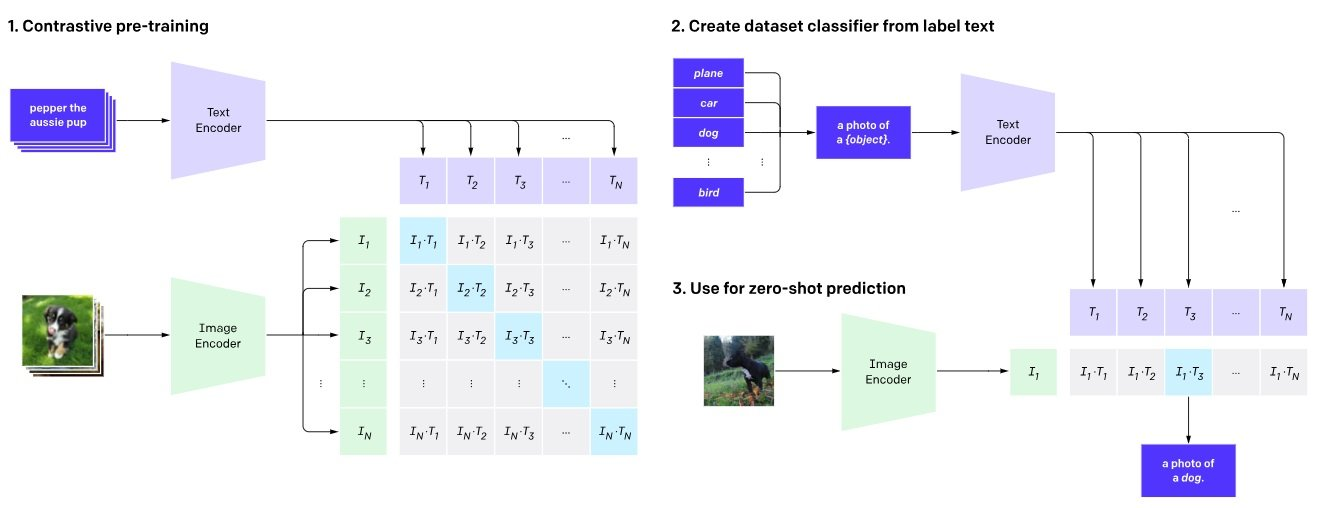

CLIP Paper: https://arxiv.org/pdf/2103.00020



**Step 1: Contrastive Pre-training**

CLIP is trained on a vast dataset consisting of apx. 400 million image-text pairs sourced from the internet. During the pre-training process, the model is fed pairs of images and their corresponding text captions. Some of these pairs are correct matches (where the caption accurately reflects the image), while others are incorrect. The model learns to create shared latent space embeddings for these pairs..

**Step 2: Create Dataset Classifiers from Label Text**

For each image, several text descriptions are generated, including the correct one and several incorrect ones. This results in a combination of positive samples (correct matches) and negative samples (mismatched pairs). These descriptions are then input into the text encoder, which generates class-specific embeddings.

At this point, the Contrastive Loss Function plays a key role. This function penalizes the model for incorrect image-text pairings and rewards it for correct matches in the latent space. It guides the model to learn representations that effectively capture the similarities between visual and textual information.

**Step 3: Zero-shot Prediction**

Now, the trained text encoder is used as a zero-shot classifier. With a new image, CLIP can make zero-shot predictions. This is done by passing it through the image encoder and the dataset classifier without fine-tuning.

CLIP calculates the cosine similarity between the embeddings of all image-text pairs. It adjusts the encoder parameters to maximize the similarity of correct pairs, while minimizing the similarity of incorrect ones.
This way, CLIP learns a multimodal embedding space where semantically related images and texts are mapped close to each other. The predicted class is the one with the highest logit value.


**Task-Specific Classes:** Several task-specific classes/APIs available when preparing data to be fed into the CLIP model.

* **CLIPImageProcessor** is used to resize (or rescale) and normalize images for model input
* **CLIPTokenizer** encodes the text.
* **CLIPProcessor** integrates both the **CLIPImageProcessor** and **CLIPTokenizer** into a single instance, facilitating the preparation of both images and text for input.
* **For Similarity Scores**  to compute image-text using the **CLIPProcessor** and **CLIPModel**


# **Image Search Engine:**
We will build an interactive tool that allows users to search for images using a simple text query. This tool leverages a pre-trained CLIP model, which is designed to match images with text. By using this model, the tool enables you to find images that closely correspond to the words or descriptions you input, making it ideal for applications that require image-text search functionality.
We will follow the strategy outlined below to develop the application.

* **Model Setup:** The script loads the pre-trained CLIP model and processor using HuggingFace's transformers library.

* **Data Download:** It downloads data (CSV) and precomputed embeddings for images from two sources (Unsplash and Movies).

* **Text Embeddings Calculation:** It computes the text embeddings of the search query using the CLIP model.

* **Similarity Search:** The embeddings of the search query are compared with those of the images to find the most similar images.

* **Interactive Widgets:** The code sets up interactive input fields and displays the search results as clickable images, with links to their sources.



In [1]:
# Install required packages
%pip install -q transformers >/dev/null

# Import libraries
import os, pandas as pd, numpy as np , urllib.request, ipywidgets as widgets
from transformers import CLIPProcessor, CLIPTextModel, CLIPModel, logging
from IPython.display import display, Markdown, HTML, clear_output


In [2]:
# Set loggin level to suppress unnessary logging info
logging.get_verbosity = lambda: logging.NOTSET

# Load pre-trained CLIP model and processor
model = CLIPModel.from_pretrained('openai/clip-vit-base-patch32')
processor = CLIPProcessor.from_pretrained('openai/clip-vit-base-patch32')
#clear out any previous output
clear_output()

In [3]:
#Function to compute text embedding
# Takes a list of strings, processes them using the CLIPProcessor, and then computes their embeddings using the CLIP model
def calc_text_embedding(list_strings):
    inputs = processor(text=list_strings, return_tensors="pt", padding=True)
    return model.get_text_features(**inputs)

# Download CSV and embedding files from a URL
# embeddings.npy & embeddings2.npy are precomputed embeddings
urllib.request.urlretrieve('https://huggingface.co/spaces/vivien/clip/raw/main/data.csv', 'data.csv')
urllib.request.urlretrieve('https://huggingface.co/spaces/vivien/clip/raw/main/data2.csv', 'data2.csv')
urllib.request.urlretrieve('https://huggingface.co/spaces/vivien/clip/resolve/main/embeddings-vit-base-patch32.npy', 'embeddings.npy')
urllib.request.urlretrieve('https://huggingface.co/spaces/vivien/clip/resolve/main/embeddings2-vit-base-patch32.npy', 'embeddings2.npy')

# Load data into pandas DataFrames and embeddings into NumPy arrays
df = {0: pd.read_csv('data.csv'), 1: pd.read_csv('data2.csv')}
embeddings = {0: np.load('embeddings.npy'), 1: np.load('embeddings2.npy')}

# Normalize the embeddings by dividing each embedding vector by its L2 norm.
# This ensures that all embeddings have unit length, which is important for comparison in the later steps
for k in [0, 1]:
    embeddings[k] = np.divide(embeddings[k], np.sqrt(np.sum(embeddings[k]**2, axis=1, keepdims=True)))

# Define the source of the data based on the dataset
source = {0: '\nSource: Unsplash', 1: '\nSource: The Movie Database (TMDB)'}


In [10]:
# Function to create HTML for displaying images in a grid
def get_html(url_list, height=200):
    html = "<div style='margin-top: 20px; display: flex; flex-wrap: wrap; justify-content: space-evenly'>"
    for url, title, link in url_list:
        html2 = f"<img title='{title}' style='height: {height}px; margin-bottom: 10px' src='{url}'>"
        if len(link) > 0:
            html2 = f"<a href='{link}' target='_blank'>" + html2 + "</a>"
        html = html + html2
    html += "</div>"
    return html

# Function to search for images based on the query
# which computes the embeddings for the user's query and
# compares them with the precomputed embeddings using a dot product
def image_search(query, n_results=24):
    text_embeddings = calc_text_embedding([query]).detach().numpy()
    k = 0 if dataset.value == 'Unsplash' else 1
    # Perform a similarity search to find the closest images
    results = np.argsort((embeddings[k]@text_embeddings.T)[:, 0])[-1:-n_results-1:-1]
    return [(df[k].iloc[i]['path'], df[k].iloc[i]['tooltip'] + source[k], df[k].iloc[i]['link']) for i in results]

# Function to handle the button click and display the results
def on_button_clicked(b):
    if len(query.value) > 0:
        results = image_search(query.value)
        output.clear_output()
        with output:
            display(HTML(get_html(results)))


In [11]:
# Create input fields and button for the user
query = widgets.Text(layout=widgets.Layout(width='400px'))
dataset = widgets.Dropdown(
    options=['Unsplash', 'Movies'],
    value='Unsplash')
button = widgets.Button(description="Search it")
output = widgets.Output()
display(widgets.HBox([query, button, dataset], layout=widgets.Layout(justify_content='center')), output)

# Attach the event handler to the button click
button.on_click(on_button_clicked)

# Also trigger the button click when the dataset dropdown is changed
dataset.observe(on_button_clicked, names='value')



Output()